In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [144]:
# Load dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Only keep Setosa (0) and Versicolor (1)
mask = y != 2
X = X[mask]
y = y[mask]

In [145]:
# Split the loaded dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)
print('Training samples:', len(y_train))
print('Testing samples:', len(y_test))

Training samples: 70
Testing samples: 30


In [146]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}

svc_l = SVC(kernel='linear', probability=True)
svc_linear = GridSearchCV(svc_l, param_grid, cv=5)
svc_linear.fit(X_train_scaled, y_train)

svc_r = SVC(kernel='rbf', probability=True)
svc_rbf = GridSearchCV(svc_r, param_grid, cv=5)
svc_rbf.fit(X_train_scaled, y_train)

best_svc = svc_linear if svc_linear.best_score_ > svc_rbf.best_score_ else svc_rbf

print('Best SVM kernel:', best_svc.best_estimator_.kernel)
print('Best C value:', best_svc.best_params_['C'])

Best SVM kernel: rbf
Best C value: 0.01


In [147]:
y_pred_svm = best_svc.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
y_proba_svm = best_svc.predict_proba(X_test_scaled)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

print(f'SVM Test Accuracy: {acc_svm:.3f}')
print(f'SVM AUC: {auc_svm:.3f}')

SVM Test Accuracy: 1.000
SVM AUC: 1.000


In [148]:
trees = {}
for criterion in ['gini', 'entropy']:
    dt = DecisionTreeClassifier(criterion=criterion, random_state=0)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_proba = dt.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    trees[criterion] = {'model': dt, 'accuracy': acc, 'fpr': fpr, 'tpr': tpr, 'auc': auc_score}
    print(f'Decision Tree ({criterion}) Accuracy: {acc:.3f}, AUC: {auc_score:.3f}')

best_tree_key = max(trees, key=lambda k: trees[k]['auc'])
best_tree = trees[best_tree_key]['model']
print(f'Best Decision Tree criterion: {best_tree_key}')

Decision Tree (gini) Accuracy: 1.000, AUC: 1.000
Decision Tree (entropy) Accuracy: 1.000, AUC: 1.000
Best Decision Tree criterion: gini


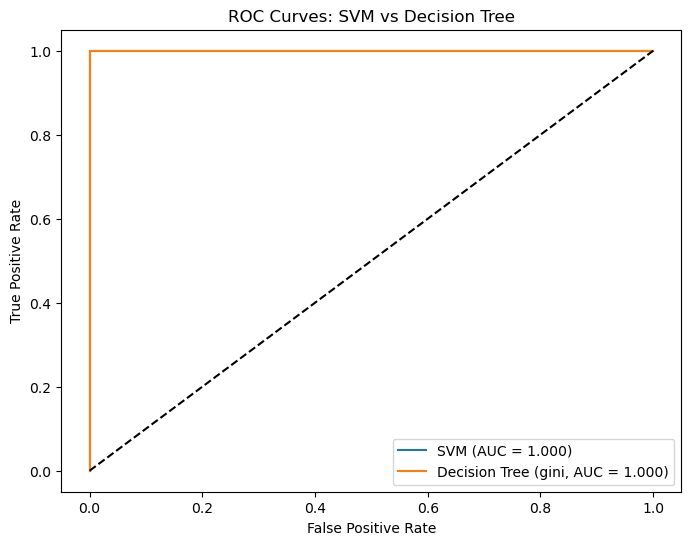

In [149]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})')
plt.plot(trees[best_tree_key]['fpr'], trees[best_tree_key]['tpr'], label=f'Decision Tree ({best_tree_key}, AUC = {trees[best_tree_key]['auc']:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves: SVM vs Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Here both the SVM and Decision Trees perform nearly equivalently. In terms of interpretability, the decision tree is better because they work on the basis of concrete rules to split the data (i.e. leaf size > 2.5cm -> Setosa), while SVMs rely on abstract hyperplanes and support vectors. Here, since the dataset is extremely clean, both methods have nearly identical performance.